In [1]:
import os
import sys

import torch

# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import text_recognizer.data
import text_recognizer.models
import text_recognizer.lit_models

In [9]:

# Configure
emnist = text_recognizer.data.EMNIST()
print(emnist.__doc__)

EMNIST dataset of handwritten characters and digits.

    "The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19
    and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset."
    From https://www.nist.gov/itl/iad/image-group/emnist-dataset

    The data split we will use is
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
    


In [10]:
emnist.prepare_data()  # download, save to disk
emnist.setup()  # create torch.utils.data.Datasets, create train/val split


In [11]:
x, y = next(iter(emnist.train_dataloader()))

t


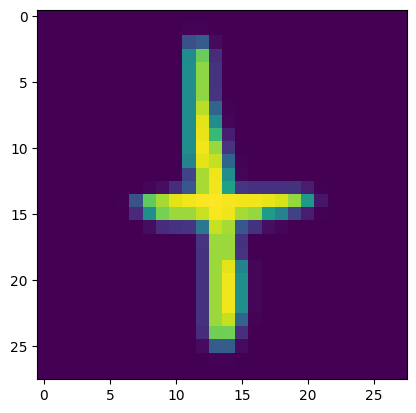

In [12]:
import random
import matplotlib.pyplot as plt


idx = random.randint(0, len(x) - 1)

print(emnist.mapping[y[idx]])
plt.imshow(x[idx].view(28,28))

In [13]:
data_config = emnist.config()

print(data_config)

{'input_dims': (1, 28, 28), 'output_dims': (1,), 'mapping': ['<B>', '<S>', '<E>', '<P>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']}


In [14]:
cnn = text_recognizer.models.CNN(data_config)
print(cnn)

CNN(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=83, bias=True)
)


In [15]:
[p.numel() for p in cnn.parameters()] 
# conv weight + bias, conv weight + bias, fc weight + bias, fc weight + bias

[576, 64, 36864, 64, 1605632, 128, 10624, 83]

In [16]:
[p.shape for p in cnn.parameters()]

[torch.Size([64, 1, 3, 3]),
 torch.Size([64]),
 torch.Size([64, 64, 3, 3]),
 torch.Size([64]),
 torch.Size([128, 12544]),
 torch.Size([128]),
 torch.Size([83, 128]),
 torch.Size([83])]

In [17]:
biggest_layer = [p for p in cnn.parameters() if p.numel() == max(p.numel() for p in cnn.parameters())][0]
biggest_layer.shape, cnn.fc_input_dim

(torch.Size([128, 12544]), 12544)

### Run Experiment - CNN

In [2]:
%run ../training/run_experiment.py --model_class CNN --data_class EMNIST 

Missing logger folder: training/logs/lightning_logs
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 1.7 M 
1 | model.conv1    | ConvBlock          | 640   
2 | model.conv2    | ConvBlock          | 36.9 K
3 | model.dropout  | Dropout            | 0     
4 | model.max_pool | MaxPool2d          | 0     
5 | model.fc1      | Linear             | 1.6 M 
6 | model.fc2      | Linear             | 10.7 K
7 | train_acc      | MulticlassAccuracy | 0     
8 | val_acc        | MulticlassAccuracy | 0     
9 | test_acc       | MulticlassAccuracy | 0     
-----------------------------

Epoch 0: 100%|██████████| 2542/2542 [07:59<00:00,  5.31it/s, loss=0.613, v_num=0, validation/loss=0.567, validation/acc=0.788]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2542/2542 [07:59<00:00,  5.31it/s, loss=0.613, v_num=0, validation/loss=0.567, validation/acc=0.788]


Best model saved at: /Users/niall.turbitt/Projects/text-recognizer/notebooks/training/logs/lightning_logs/version_0/epoch=0000-validation.loss=0.567.ckpt
Restoring states from the checkpoint path at /Users/niall.turbitt/Projects/text-recognizer/notebooks/training/logs/lightning_logs/version_0/epoch=0000-validation.loss=0.567.ckpt
Loaded model weights from checkpoint at /Users/niall.turbitt/Projects/text-recognizer/notebooks/training/logs/lightning_logs/version_0/epoch=0000-validation.loss=0.567.ckpt


Testing DataLoader 0: 100%|██████████| 422/422 [00:27<00:00, 15.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.7851559519767761
        test/loss           0.5726216435432434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Load from checkpoint

In [6]:
import training.util
from argparse import Namespace

args = Namespace(**{
    "model_class": "CNN",
    "data_class": "EMNIST"})


_, cnn = training.util.setup_data_and_model_from_args(args)

list_all_log_files = "find training/logs/lightning_logs"  # find avoids issues with \n in filenames
filter_to_ckpts = "grep \.ckpt$"  # regex match on end of line
sort_version_descending = "sort -Vr"  # uses "version" sorting (-V) and reverses (-r)
take_first = "head -n 1"  # the first n elements, n=1

latest_ckpt, = ! {list_all_log_files} | {filter_to_ckpts} | {sort_version_descending} | {take_first}
latest_ckpt

reloaded_model = text_recognizer.lit_models.BaseLitModel.load_from_checkpoint(latest_ckpt, args=args, model=cnn)

prediction: A


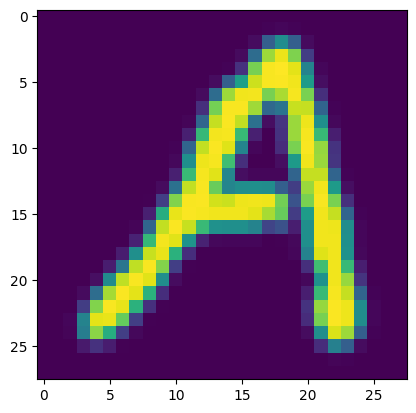

In [32]:
idx = random.randint(0, len(x) - 1)
outs = reloaded_model(x[idx:idx+1])

print("prediction:", emnist.mapping[torch.argmax(outs)])
plt.imshow(x[idx].view(28,28))